### Preprocessing e esecuzione esperimenti

In [ ]:
import pandas as pd
from datetime import datetime
import math
from utils.scalability_utils import cluster_to_dataframe
from models.SSPMF import SSPMFModel
from models.JGSMF_3 import solve_with_phases as solve_with_phases_3
from models.JGSMF_2 import solve_with_phases as solve_with_phases_2
from models.JGSMF_1 import solve_with_phases as solve_with_phases_1
from models.JGSMF import solve_with_phases as solve_with_phases_0
from models.JGSMF import solve_with_constant_bins as solve_with_constant_bins_0
from models.JGSMF_1 import solve_with_constant_bins as solve_with_constant_bins_1
from models.JGSMF_2 import solve_with_constant_bins as solve_with_constant_bins_2
from models.JGSMF_3 import solve_with_constant_bins as solve_with_constant_bins_3

In [2]:
cluster_directory = "../data/MTSP/Laporte/Tabela4/"

df = cluster_to_dataframe(cluster_directory)

df = df.sample(frac=1).reset_index(drop=True)

In [3]:
print(df['num_tools'].unique())
print(df['magazine_capacity'].unique())


[20 25 15]
[10 20  5 15]


In questo dataset tutti le istanze hanno 9 job e un numero di tools tra 15, 20 o 25. La capienza invece è tra 5, 10, 15 o 20.
Per l'analisi di scalabilità ho deciso di prendere tutte le combinazioni di numero di tools e capienza, per poi valutarne la velocità di esecuzione tra i 2 modelli

In [ ]:
scalability_df = df.drop_duplicates(subset=['num_tools', 'magazine_capacity'])

Ogni esperimento su queste istanze verrà ripetuto 5 volte per ottenenere la media dei tempi di esecuzione di ogni combinazione di parametri

In [ ]:
results = []

#SSPMF Model
print("SSPMF Model")
for index,row in scalability_df.iterrows():

    print("Instance: ", row["filename"])
    num_jobs = row['num_jobs']
    num_tools = row['num_tools']
    magazine_capacity = row['magazine_capacity']
    job_tools_requirements = row['job_tools']

    jobs = [x for x in range(1, num_jobs + 1)]
    tools = [x for x in range(1, num_tools + 1)]

    same_iteration_times = []
    mean_time = 0

    for i in range(0, 5):
        start_time = datetime.now()
        SSPMF_model = SSPMFModel(jobs, tools, magazine_capacity, job_tools_requirements)
        SSPMF_model.optimize()
        end_time = datetime.now()
        elapsed_time = (end_time - start_time).total_seconds()
        same_iteration_times.append(elapsed_time)
        
    mean_time = pd.Series(same_iteration_times).mean()
    results.append(["SSPMF",num_jobs, num_tools, magazine_capacity, mean_time])

print("-----------------------------------")
#JGSMF Model
print("JGSMF Model")
for index,row in scalability_df.iterrows():

    print("Instance:" , row["filename"])
    num_jobs = row['num_jobs']
    num_tools = row['num_tools']
    magazine_capacity = row['magazine_capacity']
    job_tools_requirements = row['job_tools']

    jobs = [x for x in range(1, num_jobs + 1)]
    tools = [x for x in range(1, num_tools + 1)]

    same_iteration_times = []
    mean_time = 0

    for i in range(0, 5):
        start_time = datetime.now()
        solution_output = solve_with_phases_3(jobs, tools, magazine_capacity, job_tools_requirements, time_limit=3600, None)
        if solution_output is not None:
            job_order, switches = solution_output
        end_time = datetime.now()
        elapsed_time = (end_time - start_time).total_seconds()
        same_iteration_times.append(elapsed_time)
        
    mean_time = pd.Series(same_iteration_times).mean()
    results.append(["JGSMF",num_jobs, num_tools, magazine_capacity, mean_time])

results_df = pd.DataFrame(results, columns=["Model", "num_jobs", "num_tools", "magazine_capacity", "time"])

In [14]:
results_df
results_df.to_csv("../results/results.csv", index=False)

Per dei risultati più attendibili, in quanto l'esecuzione sopra è stata discretamente veloce, gli esperimenti verranno ora ripetuti considerando 3 diverse istanze per combinazione di parametri ed eseguendone poi la mediana sulla media dei tempi, prendendo così il valore intermedio

In [ ]:
new_scalability_df = df.groupby(['num_tools', 'magazine_capacity']).head(3)

In [ ]:
new_results_df = []
# SSPMF Model
print("SSPMF Model")
for (num_tools, magazine_capacity), group in new_scalability_df.groupby(['num_tools', 'magazine_capacity']):
    same_iteration_times = []
    print("Group ", num_tools, magazine_capacity)

    for index, row in group.iterrows():
        print("Instance", row['filename'])
        num_jobs = row['num_jobs']
        job_tools_requirements = row['job_tools']

        jobs = [x for x in range(1, num_jobs + 1)]
        tools = [x for x in range(1, num_tools + 1)]

        iteration_times = []

        for i in range(0, 5):
            start_time = datetime.now()
            SSPMF_model = SSPMFModel(jobs, tools, magazine_capacity, job_tools_requirements)
            SSPMF_model.optimize()
            end_time = datetime.now()
            elapsed_time = (end_time - start_time).total_seconds()
            iteration_times.append(elapsed_time)

        mean_time = pd.Series(iteration_times).mean()
        same_iteration_times.append(mean_time)

    overall_median_time = pd.Series(same_iteration_times).median()
    new_results_df.append(["SSPMF", num_jobs, num_tools, magazine_capacity, overall_median_time])

print("-----------------------------------")
# JGSMF Model
print("JGSMF Model")
for (num_tools, magazine_capacity), group in new_scalability_df.groupby(['num_tools', 'magazine_capacity']):
    same_iteration_times = []
    print("Group ", num_tools, magazine_capacity)

    for index, row in group.iterrows():
        print("Instance", row['filename'])
        num_jobs = row['num_jobs']
        job_tools_requirements = row['job_tools']

        jobs = [x for x in range(1, num_jobs + 1)]
        tools = [x for x in range(1, num_tools + 1)]

        iteration_times = []

        for i in range(0, 5):
            start_time = datetime.now()
            solution_output = solve_with_phases_3(jobs, tools, magazine_capacity, job_tools_requirements, time_limit=3600, None)
            if solution_output is not None:
                job_order, switches = solution_output
            end_time = datetime.now()
            elapsed_time = (end_time - start_time).total_seconds()
            iteration_times.append(elapsed_time)

        mean_time = pd.Series(iteration_times).mean()
        same_iteration_times.append(mean_time)

    overall_median_time = pd.Series(same_iteration_times).median()
    new_results_df.append(["JGSMF", num_jobs, num_tools, magazine_capacity, overall_median_time])

new_results_df = pd.DataFrame(new_results_df, columns=["Model", "num_jobs", "num_tools", "magazine_capacity", "time"])


In [15]:
new_results_df
new_results_df.to_csv("../results/new_results.csv", index=False)

Qui vengono eseguiti gli esperimenti sulle 4 diverse implementazioni di JGSMF, ottenute aggiungendo di volta in volta diversi i cut constraint. Nello specifico:
- JGSMF -> no symmetry/performance cuts
- JGSMF_1 -> symmetry cuts
- JGSMF_2 -> performance cuts senza cliques
- JGSMF_3 -> aggiunte anche le cliques

Inoltre trattandosi di tanti esperimenti, si ottimizzerà solamente un instanza per combinazione di parametri sempre dal cluster A (Tabela 4)

In [ ]:
JGSMF_results = []

print("JGSMF Model")
for index,row in scalability_df.iterrows():

    print("Instance:" , row["filename"])
    num_jobs = row['num_jobs']
    num_tools = row['num_tools']
    magazine_capacity = row['magazine_capacity']
    job_tools_requirements = row['job_tools']

    jobs = [x for x in range(1, num_jobs + 1)]
    tools = [x for x in range(1, num_tools + 1)]

    same_iteration_times = []
    mean_time = 0
    
    num_bins = math.ceil(num_jobs/2)

    for i in range(0, 5):
        start_time = datetime.now()
        solution_output = solve_with_constant_bins_0(jobs, tools, magazine_capacity, job_tools_requirements, num_bins,3600)
        if solution_output is not None:
            job_order, switches = solution_output
        end_time = datetime.now()
        elapsed_time = (end_time - start_time).total_seconds()
        same_iteration_times.append(elapsed_time)
        
    mean_time = pd.Series(same_iteration_times).mean()
    JGSMF_results.append(["JGSMF",num_jobs, num_tools, magazine_capacity, mean_time])
print("-----------------------------------")
print("JGSMF Model 1")
for index,row in scalability_df.iterrows():

    print("Instance:" , row["filename"])
    num_jobs = row['num_jobs']
    num_tools = row['num_tools']
    magazine_capacity = row['magazine_capacity']
    job_tools_requirements = row['job_tools']

    jobs = [x for x in range(1, num_jobs + 1)]
    tools = [x for x in range(1, num_tools + 1)]

    same_iteration_times = []
    mean_time = 0
    
    num_bins = math.ceil(num_jobs/2)

    for i in range(0, 5):
        start_time = datetime.now()
        solution_output = solve_with_constant_bins_1(jobs, tools, magazine_capacity, job_tools_requirements, num_bins, 3600)
        if solution_output is not None:
            job_order, switches = solution_output
        end_time = datetime.now()
        elapsed_time = (end_time - start_time).total_seconds()
        same_iteration_times.append(elapsed_time)
        
    mean_time = pd.Series(same_iteration_times).mean()
    JGSMF_results.append(["JGSMF_1",num_jobs, num_tools, magazine_capacity, mean_time])
print("-----------------------------------")
print("JGSMF Model 2")
for index,row in scalability_df.iterrows():

    print("Instance:" , row["filename"])
    num_jobs = row['num_jobs']
    num_tools = row['num_tools']
    magazine_capacity = row['magazine_capacity']
    job_tools_requirements = row['job_tools']

    jobs = [x for x in range(1, num_jobs + 1)]
    tools = [x for x in range(1, num_tools + 1)]

    same_iteration_times = []
    mean_time = 0
    
    num_bins = math.ceil(num_jobs/2)

    for i in range(0, 5):
        start_time = datetime.now()
        solution_output = solve_with_constant_bins_2(jobs, tools, magazine_capacity, job_tools_requirements, num_bins, 3600)
        if solution_output is not None:
            job_order, switches = solution_output
        end_time = datetime.now()
        elapsed_time = (end_time - start_time).total_seconds()
        same_iteration_times.append(elapsed_time)
        
    mean_time = pd.Series(same_iteration_times).mean()
    JGSMF_results.append(["JGSMF_2",num_jobs, num_tools, magazine_capacity, mean_time])
print("-----------------------------------")
print("JGSMF Model 3")

for index,row in scalability_df.iterrows():

    print("Instance:" , row["filename"])
    num_jobs = row['num_jobs']
    num_tools = row['num_tools']
    magazine_capacity = row['magazine_capacity']
    job_tools_requirements = row['job_tools']

    jobs = [x for x in range(1, num_jobs + 1)]
    tools = [x for x in range(1, num_tools + 1)]

    same_iteration_times = []
    mean_time = 0
    
    num_bins = math.ceil(num_jobs/2)

    for i in range(0, 5):
        start_time = datetime.now()
        solution_output = solve_with_constant_bins_3(jobs, tools, magazine_capacity, job_tools_requirements, num_bins, 3600)
        if solution_output is not None:
            job_order, switches = solution_output
        end_time = datetime.now()
        elapsed_time = (end_time - start_time).total_seconds()
        same_iteration_times.append(elapsed_time)
        
    mean_time = pd.Series(same_iteration_times).mean()
    JGSMF_results.append(["JGSMF_3",num_jobs, num_tools, magazine_capacity, mean_time])

JGSMF_results_df = pd.DataFrame(JGSMF_results, columns=["Model", "num_jobs", "num_tools", "magazine_capacity", "time"])


In [6]:
JGSMF_results_df
JGSMF_results_df.to_csv("../results/JGSMF_results.csv", index=False)

### Grafici e tabelle dei risultati

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
scalability_df = pd.read_csv("../results/new_results.csv")

JGSMF_results_df = pd.read_csv("../results/JGSMF_results.csv")

scalability_df['time'] = scalability_df['time'].round(3)
JGSMF_results_df['time'] = JGSMF_results_df['time'].round(3)

Manipolazione del dataframe per ottenere il paragone dei tempi dei 4 modelli di JGSMF

In [7]:
JGSMF_comparison_df = JGSMF_results_df.pivot_table(index=["num_jobs", "num_tools", "magazine_capacity"],columns="Model",values="time").reset_index()

JGSMF_comparison_df.columns.name = None
JGSMF_comparison_df.rename(columns={"JGSMF": "JGSMF_time","JGSMF_1": "JGSMF_1_time","JGSMF_2": "JGSMF_2_time","JGSMF_3": "JGSMF_3_time"}, inplace=True)

JGSMF_comparison_df

,num_jobs,num_tools,magazine_capacity,JGSMF_time,JGSMF_1_time,JGSMF_2_time,JGSMF_3_time
0,9,15,5,0.331,0.270,0.335,0.028
1,9,15,10,0.855,0.523,0.463,0.034
2,9,20,5,0.261,0.157,0.156,0.027
3,9,20,10,1.349,0.721,0.714,0.034
4,9,20,15,0.102,0.147,0.343,0.103
5,9,25,5,0.056,0.033,0.037,0.035
6,9,25,10,3.079,0.474,0.524,0.297
7,9,25,15,3.048,0.996,0.997,0.047
8,9,25,20,0.062,0.403,0.501,0.271


Qui viene calcolato, in percentuale, quanto più veloce è una versione di JGSMF rispetto all'originale JGSMF_0 (ovvero la versione senza symmetry/perfomance cut constraints)

In [11]:
mean_time_JGSMF_0 = JGSMF_comparison_df['JGSMF_time'].mean()
mean_time_JGSMF_1 = JGSMF_comparison_df['JGSMF_1_time'].mean()
mean_time_JGSMF_2 = JGSMF_comparison_df['JGSMF_2_time'].mean()
mean_time_JGSMF_3 = JGSMF_comparison_df['JGSMF_3_time'].mean()

diff_JGSMF_1 = ((mean_time_JGSMF_0 - mean_time_JGSMF_1) / mean_time_JGSMF_0) * 100
diff_JGSMF_2 = ((mean_time_JGSMF_0 - mean_time_JGSMF_2) / mean_time_JGSMF_0) * 100
diff_JGSMF_3 = ((mean_time_JGSMF_0 - mean_time_JGSMF_3) / mean_time_JGSMF_0) * 100

print(f"JGSMF_1 is faster than JGSMF_0 by {diff_JGSMF_1:.2f}%")
print(f"JGSMF_2 is faster than JGSMF_0 by {diff_JGSMF_2:.2f}%")
print(f"JGSMF_3 is faster than JGSMF_0 by {diff_JGSMF_3:.2f}%")



JGSMF_1 is faster than JGSMF_0 by 59.27%
JGSMF_2 is faster than JGSMF_0 by 55.49%
JGSMF_3 is faster than JGSMF_0 by 90.42%


Qui sotto l'analisi di scalabilità, eseguita sul dataset scalability_df ottenuto dal cluster A con la seguente procedura:
- sono state prese 3 istanze da ogni combinazione di parametri del cluster A (Laporte/Tabela A)
- ogni istanza è stata ottimizzata dai due modelli SSPMF e JGSMF_3 5 volte e, successivamente, la media dei tempi di esecuzione è stata calcolata per ogni istanza
- alla fine di un "gruppo" di istanze (ovvero finiti tutti e 3 gli esperimenti di una combinazione) è stato fatta la mediana delle medie dei tempi di esecuzione dei modelli per prenderne il valore intermedio

In [13]:
scalability_df

,Model,num_jobs,num_tools,magazine_capacity,time
0,SSPMF,9,15,5,4.976
1,SSPMF,9,15,10,3.602
2,SSPMF,9,20,5,2.552
3,SSPMF,9,20,10,8.791
4,SSPMF,9,20,15,0.237
5,SSPMF,9,25,5,1.303
6,SSPMF,9,25,10,10.836
7,SSPMF,9,25,15,9.234
8,SSPMF,9,25,20,1.266
9,JGSMF,9,15,5,1.673


([<matplotlib.axis.XTick at 0x7fab3f195eb0>,
 [Text(15, 0, '15'), Text(20, 0, '20'), Text(25, 0, '25')])

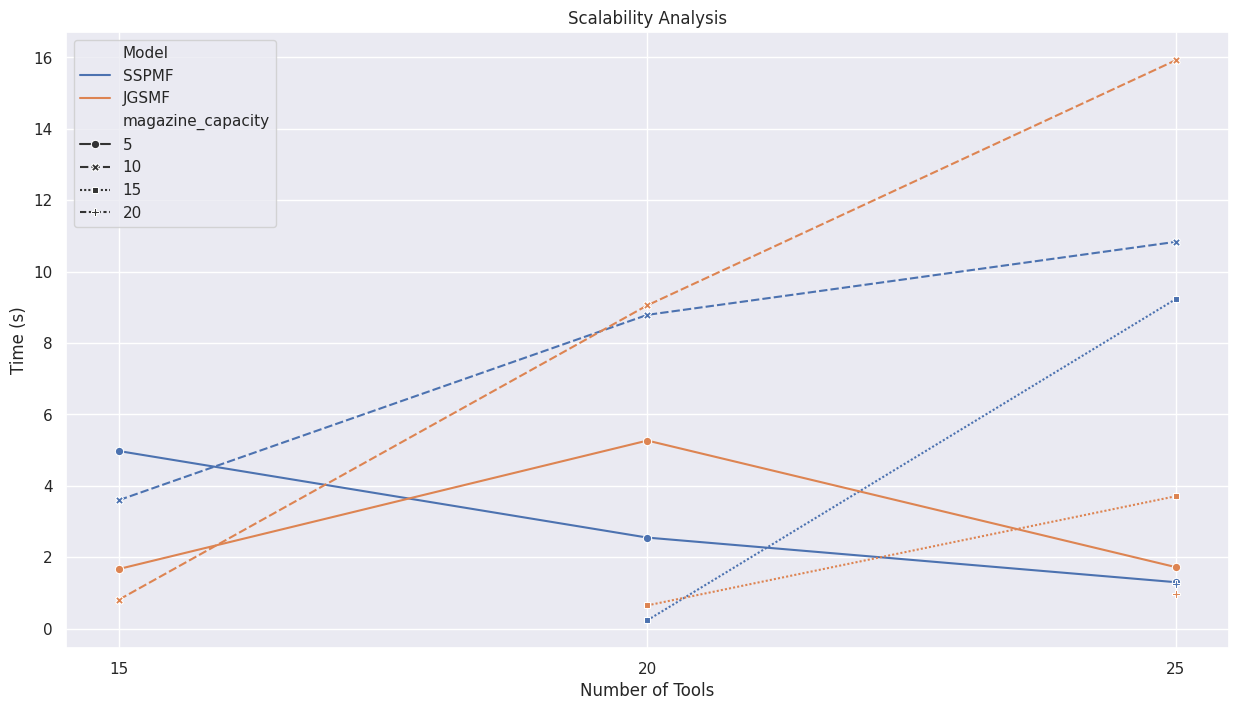

In [35]:
sns.lineplot(data=scalability_df, x="num_tools", y="time", hue="Model", style="magazine_capacity", markers=True, dashes=True)
plt.title("Scalability Analysis")
plt.ylabel("Time (s)")
plt.xlabel("Number of Tools")
plt.xticks(scalability_df['num_tools'].unique())


Text(0.5, 0.98, 'Scalability Analysis by Number of Tools')

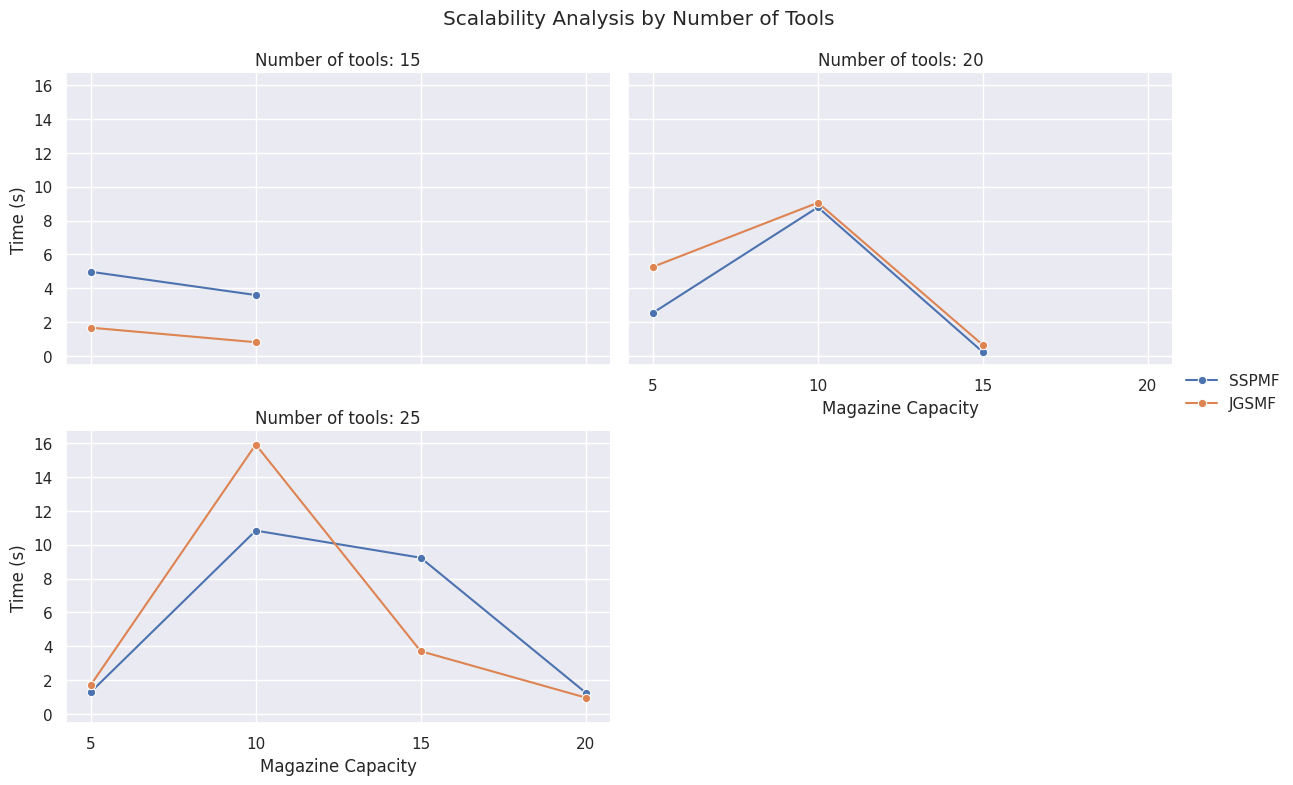

In [27]:
g = sns.FacetGrid(scalability_df, col="num_tools", col_wrap=2, height=4, aspect=1.5)

g.map(sns.lineplot, "magazine_capacity", "time", "Model", marker="o")

g.set_titles(col_template="Number of tools: {col_name}")
g.set_axis_labels("Magazine Capacity", "Time (s)")
g.add_legend()

for ax in g.axes.flat:
    num_tools = int(ax.get_title().split(": ")[1])
    subset = scalability_df[scalability_df['num_tools'] == num_tools]
    unique_magazine_capacity = sorted(subset['magazine_capacity'].unique())
    ax.set_xticks(unique_magazine_capacity)
    ax.set_xticklabels(unique_magazine_capacity)

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Scalability Analysis by Number of Tools")